# 악플 분류기 - 다중분류
- 데이터: https://github.com/smilegate-ai/korean_unsmile_dataset

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [8]:
# 데이터 불러오기
train_df = pd.read_csv("/content/unsmile_train_v1.0.tsv",delimiter='\t')
test_df = pd.read_csv("/content/unsmile_valid_v1.0.tsv", delimiter='\t')

In [ ]:
print(train_df.shape, test_df.shape)
train_df.head(3)

(15005, 12) (3737, 12)


,문장,여성/가족,남성,성소수자,인종/국적,연령,지역,종교,기타 혐오,악플/욕설,clean,개인지칭
0,일안하는 시간은 쉬고싶어서 그런게 아닐까,0,0,0,0,0,0,0,0,0,1,0
1,아동성범죄와 페도버는 기록바 끊어져 영원히 고통 받는다. 무슬림 50퍼 근친이다. ...,0,0,0,0,0,0,1,0,0,0,0
2,루나 솔로앨범 나왔을 때부터 머모 기운 있었음 ㅇㅇ Keep o doin 진짜 띵...,0,0,0,0,0,0,0,0,0,1,0


## 데이터 전처리

- train dataset

In [ ]:
# Null 값 체크
train_df.isna().sum().sum()

0

In [9]:
# 중복 데이터 확인
print(train_df.shape, train_df.문장.nunique())

# 중복 데이터 제거
train_df.drop_duplicates(subset=['문장'], inplace=True)
train_df.shape

(15005, 12) 15004


(15004, 12)

In [10]:
# 분류가 안되어 있는 데이터 확인
print(train_df[train_df.sum(axis=1) == 0].index)

# 분류 안되어 있는 데이터 삭제
train_df = train_df[train_df.sum(axis=1) != 0]

Int64Index([5876, 11942], dtype='int64')


- test dataset

In [ ]:
# Null 값 체크
test_df.isna().sum().sum()

0

In [ ]:
# 중복 데이터 확인
test_df.shape, test_df.문장.nunique()

((3737, 12), 3737)

In [ ]:
# 분류가 안되어 있는 데이터 확인
test_df[test_df.sum(axis=1) == 0]

,문장,여성/가족,남성,성소수자,인종/국적,연령,지역,종교,기타 혐오,악플/욕설,clean,개인지칭


## 텍스트 전처리

- train data

In [11]:
# 한글 이외의 문자는 공백으로 처리하고 strip
train_df.문장 = train_df.문장.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ').str.strip()
train_df.문장.replace('', np.nan, inplace=True)
print(train_df.문장.isna().sum())
train_df.dropna(how='any', inplace=True)
train_df.reset_index(drop=True, inplace=True)
train_df.shape

24


(14978, 12)

- test data

In [12]:
# 한글 이외의 문자는 공백으로 처리하고 strip
test_df.문장 = test_df.문장.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ').str.strip()
test_df.문장.replace('', np.nan, inplace=True)
print(test_df.문장.isna().sum())
test_df.dropna(how='any', inplace=True)
test_df.reset_index(drop=True, inplace=True)
test_df.shape

7


(3730, 12)

- 데이터 분포

In [ ]:
train_df.sum()[1:]

여성/가족    1599
남성       1347
성소수자     1140
인종/국적    1727
연령        603
지역       1052
종교       1181
기타 혐오     569
악플/욕설    3141
clean    3718
개인지칭      315
dtype: object

In [ ]:
test_df.sum()[1:]

여성/가족    393
남성       334
성소수자     280
인종/국적    426
연령       146
지역       260
종교       290
기타 혐오    134
악플/욕설    785
clean    930
개인지칭      74
dtype: object

## 악플 데이터만 추출

In [7]:
train_df = train_df[train_df['clean'] ==0]
test_df = test_df[test_df['clean'] ==0]

In [ ]:
train_df = train_df.iloc[:, :10]
test_df = test_df.iloc[:, :10]

- 이중 레이블 나누기
- 레이블 열 생성

In [ ]:
# 라벨링
df = pd.concat([train_df['문장'], train_df.iloc[:, 1:] * range(1, 10)], axis=1)

dataset_train = pd.DataFrame()
for i in range(1, 10):
  data = df.loc[df.iloc[:, i] > 0][['문장', df.columns[i]]]
  data.columns = ['문장', '라벨']
  dataset_train = pd.concat([dataset_train, data])
  
  dataset_train.reset_index(drop=True, inplace=True)

- 오버 샘플링

In [ ]:
x = dataset_train['문장'].values.reshape(-1, 1)
y = dataset_train.iloc[:, 1:].values

In [ ]:
from imblearn.over_sampling import RandomOverSampler
X_resampled, y_resampled = RandomOverSampler(random_state=0).fit_resample(x, y)

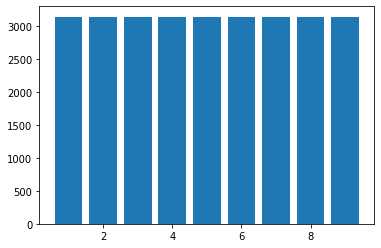

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

counter = Counter(y_resampled)
plt.bar(counter.keys(), counter.values())
plt.show()

## 한글 형태소 분석

In [ ]:
# Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab_light_220429.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 9.03 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 495 kB/s 
     |████████████████████████████████| 453 kB 43.9 MB/s 
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-06-10 08:36:26--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c5:2ef4, 2406:da00:ff00::3403:4be7, ...
Connecting to bitbucket.org (bi

In [ ]:
from konlpy.tag import Mecab
from tqdm.notebook import tqdm

In [ ]:
mecab = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','을','ㅋㅋ','ㅠㅠ','ㅎㅎ']

In [ ]:
train_data = []
for sentence in tqdm(X_resampled):
  morphs = mecab.morphs(sentence[0])
  tmp_X = [word for word in morphs if word not in stopwords]
  train_data.append(tmp_X)

  0%|          | 0/28269 [00:00<?, ?it/s]

In [ ]:
test_data = []
for sentence in tqdm(test_df.문장):
  morphs = mecab.morphs(sentence)
  tmp_X = [word for word in morphs if word not in stopwords]
  test_data.append(tmp_X)

  0%|          | 0/2800 [00:00<?, ?it/s]

## 토큰화

In [ ]:
import numpy as np
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(train_data)

In [ ]:
# 등장 빈도가 3 미만인 것의 갯수
threshold = 3
total_cnt = len(t.word_index)   # 단어의 수
rare_cnt = 0                    # 등장 빈도가 threshold 보다 작은 단어의 갯수
total_freq = 0                  # 훈련 데이터의 전체 단어의 빈도수의 합
rare_freq = 0                   # 등장 빈도가 threshold 보다 작은 단어의 등장 빈도수의 합

In [ ]:
for key, value in t.word_counts.items():
  total_freq += value
  if value < threshold:
    rare_cnt += 1
    rare_freq += value

In [ ]:
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print(f'등장 빈도가 {threshold - 1}번 이하인 희귀 단어의 수: {rare_cnt}')
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 16999
등장 빈도가 2번 이하인 희귀 단어의 수: 5923
단어 집합에서 희귀 단어의 비율: 34.843226072121894
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.5931996532973676


In [ ]:
# 모든 단어 사용
vocab_size = total_cnt + 2
vocab_size

17001

In [ ]:
t = Tokenizer(num_words=vocab_size, oov_token='OOV')
t.fit_on_texts(train_data)
X_train = t.texts_to_sequences(train_data)
X_test = t.texts_to_sequences(test_data)

In [ ]:
# 데이터의 최대/평균 길이
max(len(s) for s in X_train), sum(map(len, X_train)) / len(X_train)

(74, 18.202341787824118)

In [ ]:
# 악플 길이를 60으로 설정
max_len = 60

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

X_train.shape, X_test.shape

((28269, 60), (2800, 60))

In [ ]:
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y_resampled)
Y_train = np.delete(Y_train, 0, 1)
Y_test = test_df.iloc[:, 1:].values
Y_train.shape, Y_test.shape

((28269, 9), (2800, 9))

## 모델 정의/설정/학습

In [ ]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, GlobalMaxPooling1D, Dropout, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## 셀프 어텐션

### 멀티 헤드 어텐션
- 트랜스포머 인코더의 첫번째 서브층

In [ ]:
import tensorflow as tf

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim # d_model
        self.num_heads = num_heads

        assert embedding_dim % self.num_heads == 0

        self.projection_dim = embedding_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embedding_dim)
        self.key_dense = tf.keras.layers.Dense(embedding_dim)
        self.value_dense = tf.keras.layers.Dense(embedding_dim)
        self.dense = tf.keras.layers.Dense(embedding_dim)

    def scaled_dot_product_attention(self, query, key, value):
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        depth = tf.cast(tf.shape(key)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)
        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output, attention_weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]

        # (batch_size, seq_len, embedding_dim)
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # (batch_size, num_heads, seq_len, projection_dim)
        query = self.split_heads(query, batch_size)  
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention, _ = self.scaled_dot_product_attention(query, key, value)
        # (batch_size, seq_len, num_heads, projection_dim)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

        # (batch_size, seq_len, embedding_dim)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embedding_dim))
        outputs = self.dense(concat_attention)
        return outputs

### 인코더 설계하기
- 두번째 서브칭인 포지션 와이즈 피드 포워드 신경망 추가

In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(embedding_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(dff, activation="relu"),
             tf.keras.layers.Dense(embedding_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs) # 첫번째 서브층 : 멀티 헤드 어텐션
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output) # Add & Norm
        ffn_output = self.ffn(out1) # 두번째 서브층 : 포지션 와이즈 피드 포워드 신경망
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output) # Add & Norm

### 포지션 임베딩
- 임베딩 층을 사용하되, 위치 벡터 학습하도록 임베딩 층의 첫번째 인자로 단어 집합의 크기가 아니라 문장의 최대 길이를 넣어줌

In [ ]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, vocab_size, embedding_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.pos_emb = tf.keras.layers.Embedding(max_len, embedding_dim)

    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=max_len, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

### 데이터 전처리

In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

### 모델 정의/학습

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
del model

In [ ]:
embedding_dim = 32  # 각 단어의 임베딩 벡터의 차원
num_heads = 2  # 어텐션 헤드의 수
dff = 32  # 포지션 와이즈 피드 포워드 신경망의 은닉층의 크기

inputs = tf.keras.layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embedding_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embedding_dim, num_heads, dff)
x = transformer_block(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(20, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(9, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 60)]              0         
                                                                 
 token_and_position_embeddin  (None, 60, 32)           545952    
 g_14 (TokenAndPositionEmbed                                     
 ding)                                                           
                                                                 
 transformer_block_14 (Trans  (None, 60, 32)           6464      
 formerBlock)                                                    
                                                                 
 global_max_pooling1d_6 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_40 (Dropout)        (None, 32)                0   

In [ ]:
model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])
model_path = 'best-transforemr-attention.h5py'
mc = ModelCheckpoint(model_path, verbose=1, save_best_only=True)
es = EarlyStopping(patience=3)

history = model.fit(X_train, Y_train, validation_split=0.2,
                    batch_size=32, epochs=100, callbacks=[mc, es])

Epoch 1/100
703/707 [============================>.] - ETA: 0s - loss: 1.5631 - accuracy: 0.4598
Epoch 1: val_loss improved from inf to 2.05308, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


707/707 [==============================] - 11s 13ms/step - loss: 1.5605 - accuracy: 0.4611 - val_loss: 2.0531 - val_accuracy: 0.3753
Epoch 2/100
704/707 [============================>.] - ETA: 0s - loss: 0.8093 - accuracy: 0.7567
Epoch 2: val_loss improved from 2.05308 to 1.70508, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


707/707 [==============================] - 8s 12ms/step - loss: 0.8085 - accuracy: 0.7569 - val_loss: 1.7051 - val_accuracy: 0.4367
Epoch 3/100
707/707 [==============================] - ETA: 0s - loss: 0.5802 - accuracy: 0.8247
Epoch 3: val_loss improved from 1.70508 to 1.54638, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


707/707 [==============================] - 9s 12ms/step - loss: 0.5802 - accuracy: 0.8247 - val_loss: 1.5464 - val_accuracy: 0.4823
Epoch 4/100
701/707 [============================>.] - ETA: 0s - loss: 0.4476 - accuracy: 0.8600
Epoch 4: val_loss improved from 1.54638 to 1.18753, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


707/707 [==============================] - 8s 12ms/step - loss: 0.4476 - accuracy: 0.8601 - val_loss: 1.1875 - val_accuracy: 0.5444
Epoch 5/100
704/707 [============================>.] - ETA: 0s - loss: 0.3719 - accuracy: 0.8796
Epoch 5: val_loss improved from 1.18753 to 0.94601, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


707/707 [==============================] - 8s 12ms/step - loss: 0.3717 - accuracy: 0.8796 - val_loss: 0.9460 - val_accuracy: 0.6599
Epoch 6/100
701/707 [============================>.] - ETA: 0s - loss: 0.3248 - accuracy: 0.8890
Epoch 6: val_loss improved from 0.94601 to 0.86791, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


707/707 [==============================] - 9s 12ms/step - loss: 0.3245 - accuracy: 0.8890 - val_loss: 0.8679 - val_accuracy: 0.6650
Epoch 7/100
706/707 [============================>.] - ETA: 0s - loss: 0.2861 - accuracy: 0.8967
Epoch 7: val_loss improved from 0.86791 to 0.78280, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


707/707 [==============================] - 8s 12ms/step - loss: 0.2862 - accuracy: 0.8967 - val_loss: 0.7828 - val_accuracy: 0.7032
Epoch 8/100
704/707 [============================>.] - ETA: 0s - loss: 0.2625 - accuracy: 0.9005
Epoch 8: val_loss improved from 0.78280 to 0.65197, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


707/707 [==============================] - 9s 12ms/step - loss: 0.2620 - accuracy: 0.9007 - val_loss: 0.6520 - val_accuracy: 0.7239
Epoch 9/100
703/707 [============================>.] - ETA: 0s - loss: 0.2474 - accuracy: 0.9035
Epoch 9: val_loss did not improve from 0.65197
707/707 [==============================] - 5s 8ms/step - loss: 0.2472 - accuracy: 0.9035 - val_loss: 0.6718 - val_accuracy: 0.7053
Epoch 10/100
702/707 [============================>.] - ETA: 0s - loss: 0.2336 - accuracy: 0.9076
Epoch 10: val_loss did not improve from 0.65197
707/707 [==============================] - 5s 8ms/step - loss: 0.2336 - accuracy: 0.9077 - val_loss: 0.6978 - val_accuracy: 0.6986
Epoch 11/100
700/707 [============================>.] - ETA: 0s - loss: 0.2194 - accuracy: 0.9116
Epoch 11: val_loss improved from 0.65197 to 0.56175, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


707/707 [==============================] - 9s 13ms/step - loss: 0.2198 - accuracy: 0.9113 - val_loss: 0.5617 - val_accuracy: 0.7377
Epoch 12/100
700/707 [============================>.] - ETA: 0s - loss: 0.2152 - accuracy: 0.9096
Epoch 12: val_loss improved from 0.56175 to 0.53852, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


707/707 [==============================] - 9s 12ms/step - loss: 0.2151 - accuracy: 0.9096 - val_loss: 0.5385 - val_accuracy: 0.7218
Epoch 13/100
705/707 [============================>.] - ETA: 0s - loss: 0.2031 - accuracy: 0.9141
Epoch 13: val_loss did not improve from 0.53852
707/707 [==============================] - 5s 8ms/step - loss: 0.2029 - accuracy: 0.9142 - val_loss: 0.6186 - val_accuracy: 0.7230
Epoch 14/100
703/707 [============================>.] - ETA: 0s - loss: 0.1996 - accuracy: 0.9139
Epoch 14: val_loss improved from 0.53852 to 0.48603, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


707/707 [==============================] - 8s 12ms/step - loss: 0.1996 - accuracy: 0.9139 - val_loss: 0.4860 - val_accuracy: 0.7457
Epoch 15/100
707/707 [==============================] - ETA: 0s - loss: 0.1966 - accuracy: 0.9154
Epoch 15: val_loss did not improve from 0.48603
707/707 [==============================] - 5s 8ms/step - loss: 0.1966 - accuracy: 0.9154 - val_loss: 0.5239 - val_accuracy: 0.7230
Epoch 16/100
700/707 [============================>.] - ETA: 0s - loss: 0.1926 - accuracy: 0.9167
Epoch 16: val_loss improved from 0.48603 to 0.47783, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


707/707 [==============================] - 8s 12ms/step - loss: 0.1933 - accuracy: 0.9165 - val_loss: 0.4778 - val_accuracy: 0.7204
Epoch 17/100
707/707 [==============================] - ETA: 0s - loss: 0.1839 - accuracy: 0.9186
Epoch 17: val_loss did not improve from 0.47783
707/707 [==============================] - 5s 8ms/step - loss: 0.1839 - accuracy: 0.9186 - val_loss: 0.5032 - val_accuracy: 0.7152
Epoch 18/100
705/707 [============================>.] - ETA: 0s - loss: 0.1855 - accuracy: 0.9155
Epoch 18: val_loss did not improve from 0.47783
707/707 [==============================] - 5s 8ms/step - loss: 0.1854 - accuracy: 0.9155 - val_loss: 0.4881 - val_accuracy: 0.7152
Epoch 19/100
702/707 [============================>.] - ETA: 0s - loss: 0.1771 - accuracy: 0.9193
Epoch 19: val_loss did not improve from 0.47783
707/707 [==============================] - 6s 8ms/step - loss: 0.1773 - accuracy: 0.9192 - val_loss: 0.4998 - val_accuracy: 0.7211


In [ ]:
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

88/88 [==============================] - 1s 4ms/step - loss: 2.2721 - accuracy: 0.6971


[2.272127151489258, 0.6971428394317627]

In [ ]:
import re

def sentiment_predict(review, best_model,tokenizer=t, max_len=max_len):
    review = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ',review).strip()
    morphs = mecab.morphs(review)
    morphs = [word for word in morphs if word not in stopwords]
    encoded = tokenizer.texts_to_sequences([morphs])
    padded = pad_sequences(encoded, maxlen=max_len)
    score = best_model.predict(padded)
    class_text = test_df.columns[1:]

    return print(f"'{review}'\n {score[0][score.argmax()]*100}%의 확률로 {class_text[score.argmax()]}에 대한 악플입니다.")

In [ ]:
num=1210
text = test_df['문장'][num]
print(sentiment_predict(text, best_model,tokenizer=t, max_len=max_len))
print(test_df.loc[num])

'근데 아프가니스탄은 이슬람권 국가중에서도 거의 막장수준이라    다른국가 히잡안쓰는애들도 꽤 많음'
 62.24408149719238%의 확률로 인종/국적에 대한 악플입니다.
None
문장       근데 아프가니스탄은 이슬람권 국가중에서도 거의 막장수준이라    다른국가 히잡안쓰는...
여성/가족                                                    0
남성                                                       0
성소수자                                                     0
인종/국적                                                    1
연령                                                       0
지역                                                       0
종교                                                       0
기타 혐오                                                    0
악플/욕설                                                    0
Name: 1210, dtype: object


## CNN

In [ ]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, GlobalMaxPooling1D, Dropout, Concatenate, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
inputs = Input(shape=(max_len,))
em = Embedding(vocab_size, 128, input_length=max_len)(inputs)

x_1 = Conv1D(64, 5, activation='relu')(em)
X_1 = Dropout(0.5)(x_1)

x_2 = Conv1D(32, 5, activation='relu')(em)
x_2 = Dropout(0.5)(x_2)

x = Concatenate()([x_1, x_2])
x = GlobalMaxPooling1D()(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(9, activation='sigmoid')(x)

model1 = Model(inputs = inputs, outputs = outputs)
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 60, 128)      2176128     ['input_2[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 56, 32)       20512       ['embedding_1[0][0]']            
                                                                                                  
 conv1d_2 (Conv1D)              (None, 56, 64)       41024       ['embedding_1[0][0]']            
                                                                                            

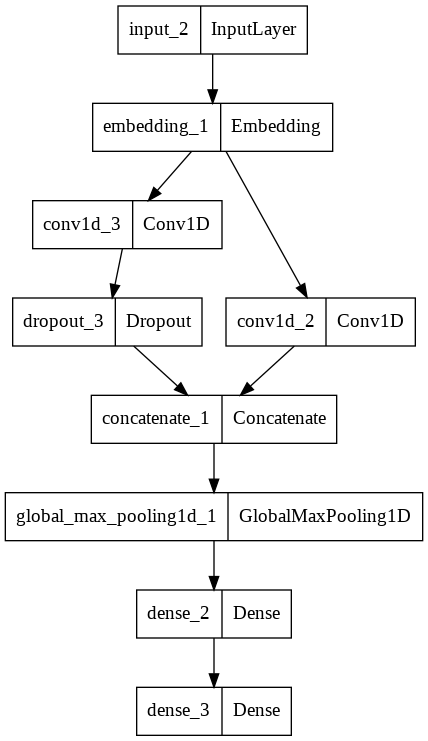

In [ ]:
# 모델 구조 그려보기
from tensorflow.keras.utils import plot_model
plot_model(model1)

In [ ]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1_path = 'best-cnn.h5'
mc1 = ModelCheckpoint(model1_path, verbose=1, save_best_only=True)
es1 = EarlyStopping(patience=5)

In [ ]:
hist = model1.fit(
    X_train, Y_train, validation_split=0.2,
    epochs=30, batch_size=128, callbacks=[mc1, es1]
)

Epoch 1/30
177/177 [==============================] - ETA: 0s - loss: 1.4381 - accuracy: 0.5367
Epoch 1: val_loss improved from inf to 1.90616, saving model to best-cnn.h5
177/177 [==============================] - 39s 204ms/step - loss: 1.4381 - accuracy: 0.5367 - val_loss: 1.9062 - val_accuracy: 0.3284
Epoch 2/30
177/177 [==============================] - ETA: 0s - loss: 0.5564 - accuracy: 0.8279
Epoch 2: val_loss improved from 1.90616 to 1.43654, saving model to best-cnn.h5
177/177 [==============================] - 20s 112ms/step - loss: 0.5564 - accuracy: 0.8279 - val_loss: 1.4365 - val_accuracy: 0.4701
Epoch 3/30
177/177 [==============================] - ETA: 0s - loss: 0.3673 - accuracy: 0.8769
Epoch 3: val_loss improved from 1.43654 to 1.12274, saving model to best-cnn.h5
177/177 [==============================] - 20s 112ms/step - loss: 0.3673 - accuracy: 0.8769 - val_loss: 1.1227 - val_accuracy: 0.5952
Epoch 4/30
177/177 [==============================] - ETA: 0s - loss: 0.29

In [ ]:
best_model1 = load_model(model1_path)
best_model1.evaluate(X_test, Y_test)

88/88 [==============================] - 1s 7ms/step - loss: 1.5304 - accuracy: 0.7182


[1.530423879623413, 0.7182142734527588]

# clean포함 다중분류

## 데이터 전처리

In [13]:
# 개인지칭 라벨은 삭제
train_df = train_df.iloc[:, :11]
test_df = test_df.iloc[:, :11]
train_df.shape, test_df.shape

((14978, 11), (3730, 11))

- 오버샘플링

In [14]:
# 라벨링
df = pd.concat([train_df['문장'], train_df.iloc[:, 1:] * range(1, 11)], axis=1)

dataset_train = pd.DataFrame()
for i in range(1, 11):
  data = df.loc[df.iloc[:, i] > 0][['문장', df.columns[i]]]
  data.columns = ['문장', '라벨']
  dataset_train = pd.concat([dataset_train, data])
  
  dataset_train.reset_index(drop=True, inplace=True)

In [15]:
x = dataset_train['문장'].values.reshape(-1, 1)
y = dataset_train.iloc[:, 1:].values

In [16]:
from imblearn.over_sampling import RandomOverSampler
X_resampled, y_resampled = RandomOverSampler(random_state=0).fit_resample(x, y)

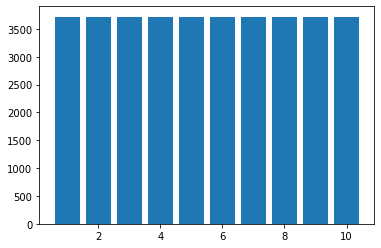

In [17]:
import matplotlib.pyplot as plt
from collections import Counter

counter = Counter(y_resampled)
plt.bar(counter.keys(), counter.values())
plt.show()

## 한글 형태소 분석

In [18]:
# Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab_light_220429.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 18.32 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 453 kB 49.1 MB/s 
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-06-13 01:47:14--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::3403:4be7, 2406:da00:ff00::22c5:2ef4, ...
Connecting to bitbucket.org (b

In [19]:
from konlpy.tag import Mecab
from tqdm.notebook import tqdm

In [20]:
mecab = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','을','ㅋㅋ','ㅠㅠ','ㅎㅎ']

In [21]:
train_data = []
for sentence in tqdm(X_resampled):
  morphs = mecab.morphs(sentence[0])
  tmp_X = [word for word in morphs if word not in stopwords]
  train_data.append(tmp_X)

  0%|          | 0/37180 [00:00<?, ?it/s]

In [22]:
test_data = []
for sentence in tqdm(test_df.문장):
  morphs = mecab.morphs(sentence)
  tmp_X = [word for word in morphs if word not in stopwords]
  test_data.append(tmp_X)

  0%|          | 0/3730 [00:00<?, ?it/s]

## 토큰화

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(train_data)

In [24]:
# 등장 빈도가 3 미만인 것의 갯수
threshold = 3
total_cnt = len(t.word_index)   # 단어의 수
rare_cnt = 0                    # 등장 빈도가 threshold 보다 작은 단어의 갯수
total_freq = 0                  # 훈련 데이터의 전체 단어의 빈도수의 합
rare_freq = 0                   # 등장 빈도가 threshold 보다 작은 단어의 등장 빈도수의 합

In [25]:
for key, value in t.word_counts.items():
  total_freq += value
  if value < threshold:
    rare_cnt += 1
    rare_freq += value

In [26]:
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print(f'등장 빈도가 {threshold - 1}번 이하인 희귀 단어의 수: {rare_cnt}')
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 19677
등장 빈도가 2번 이하인 희귀 단어의 수: 7165
단어 집합에서 희귀 단어의 비율: 36.41307109823652
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.4487064738927362


In [27]:
# 모든 단어 사용
vocab_size = total_cnt + 2
vocab_size

19679

In [28]:
t = Tokenizer(num_words=vocab_size, oov_token='OOV')
t.fit_on_texts(train_data)
X_train = t.texts_to_sequences(train_data)
X_test = t.texts_to_sequences(test_data)

In [29]:
# 악플 길이를 100으로 설정
max_len = 100

In [30]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

X_train.shape, X_test.shape

((37180, 100), (3730, 100))

In [31]:
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y_resampled)
Y_train = np.delete(Y_train, 0, 1)
Y_test = test_df.iloc[:, 1:].values
Y_train.shape, Y_test.shape

((37180, 10), (3730, 10))

## 모델 정의/설정/학습

### CNN

In [ ]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, GlobalMaxPooling1D, Dropout, Concatenate, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
inputs = Input(shape=(max_len,))
em = Embedding(vocab_size, 128, input_length=max_len)(inputs)

x_1 = Conv1D(64, 5, activation='relu')(em)
X_1 = Dropout(0.5)(x_1)

x_2 = Conv1D(32, 5, activation='relu')(em)
x_2 = Dropout(0.5)(x_2)

x = Concatenate()([x_1, x_2])
x = GlobalMaxPooling1D()(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

model1 = Model(inputs = inputs, outputs = outputs)
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 60, 128)      2518912     ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 56, 32)       20512       ['embedding[0][0]']              
                                                                                                  
 conv1d (Conv1D)                (None, 56, 64)       41024       ['embedding[0][0]']              
                                                                                              

In [ ]:
# 모델 구조 그려보기
from tensorflow.keras.utils import plot_model
plot_model(model1)

In [ ]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1_path = 'best-cnn.h5'
mc1 = ModelCheckpoint(model1_path, verbose=1, save_best_only=True)
es1 = EarlyStopping(patience=5)

In [ ]:
hist = model1.fit(
    X_train, Y_train, validation_split=0.2,
    epochs=30, batch_size=128, callbacks=[mc1, es1]
)

Epoch 1/30
233/233 [==============================] - ETA: 0s - loss: 1.4142 - accuracy: 0.5435
Epoch 1: val_loss improved from inf to 1.94120, saving model to best-cnn2.h5
233/233 [==============================] - 47s 195ms/step - loss: 1.4142 - accuracy: 0.5435 - val_loss: 1.9412 - val_accuracy: 0.4016
Epoch 2/30
233/233 [==============================] - ETA: 0s - loss: 0.6018 - accuracy: 0.8008
Epoch 2: val_loss improved from 1.94120 to 1.37161, saving model to best-cnn2.h5
233/233 [==============================] - 31s 135ms/step - loss: 0.6018 - accuracy: 0.8008 - val_loss: 1.3716 - val_accuracy: 0.5184
Epoch 3/30
233/233 [==============================] - ETA: 0s - loss: 0.3918 - accuracy: 0.8679
Epoch 3: val_loss improved from 1.37161 to 0.96531, saving model to best-cnn2.h5
233/233 [==============================] - 31s 132ms/step - loss: 0.3918 - accuracy: 0.8679 - val_loss: 0.9653 - val_accuracy: 0.6768
Epoch 4/30
233/233 [==============================] - ETA: 0s - loss: 0

In [ ]:
best_model1 = load_model(model1_path)
best_model1.evaluate(X_test, Y_test)

117/117 [==============================] - 1s 8ms/step - loss: 1.5055 - accuracy: 0.6378


[1.5054835081100464, 0.6378015875816345]

### 2. BiLSTM
- Embedding Layer
- Bidirectional LSTM (Dropout: 10%)
- 1-Dimension Global Max Pooling
- 1-Dimension Fully Connected Layer
- Softmax Activation

In [45]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPooling1D, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [46]:
inputs = Input(shape=(max_len,))
em = Embedding(vocab_size, 128, input_length=max_len)(inputs)

x = Bidirectional(LSTM(128, return_sequences=True))(em)
x = Dropout(0.1)(x)
x = GlobalMaxPooling1D()(x)
outputs = Dense(10, activation='softmax')(x)

model2 = Model(inputs = inputs, outputs = outputs)
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 100, 128)          2518912   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 256)         263168    
 l)                                                              
                                                                 
 dropout_4 (Dropout)         (None, 100, 256)          0         
                                                                 
 global_max_pooling1d_1 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 10)                2570

In [47]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2_path = 'best-bilstm.h5'
mc2 = ModelCheckpoint(model2_path, verbose=1, save_best_only=True)
es2 = EarlyStopping(patience=3)

In [48]:
hist = model2.fit(
    X_train, Y_train, validation_split=0.2,
    epochs=30, batch_size=128, callbacks=[mc2, es2]
)

Epoch 1/30
233/233 [==============================] - ETA: 0s - loss: 1.4478 - accuracy: 0.5076
Epoch 1: val_loss improved from inf to 2.08873, saving model to best-bilstm.h5
233/233 [==============================] - 14s 35ms/step - loss: 1.4478 - accuracy: 0.5076 - val_loss: 2.0887 - val_accuracy: 0.3406
Epoch 2/30
232/233 [============================>.] - ETA: 0s - loss: 0.5953 - accuracy: 0.7964
Epoch 2: val_loss improved from 2.08873 to 1.58532, saving model to best-bilstm.h5
233/233 [==============================] - 5s 22ms/step - loss: 0.5953 - accuracy: 0.7965 - val_loss: 1.5853 - val_accuracy: 0.4692
Epoch 3/30
232/233 [============================>.] - ETA: 0s - loss: 0.4065 - accuracy: 0.8592
Epoch 3: val_loss improved from 1.58532 to 1.26158, saving model to best-bilstm.h5
233/233 [==============================] - 5s 22ms/step - loss: 0.4066 - accuracy: 0.8592 - val_loss: 1.2616 - val_accuracy: 0.5313
Epoch 4/30
233/233 [==============================] - ETA: 0s - loss: 

In [49]:
best_model2 = load_model(model2_path)
best_model2.evaluate(X_test, Y_test)

117/117 [==============================] - 2s 8ms/step - loss: 1.6295 - accuracy: 0.6338


[1.629464030265808, 0.6337801814079285]

### BiLSTM + LSTM
- Embedding Layer
- Bidirectional LSTM + Residual Connection from Embedding Layer
- Forward LSTM
- 1-Dimsension Global Max Pooling
- 1-Dimension Fully Connected Layer (Dropout: 50%)

In [50]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPooling1D, Dropout, Bidirectional, LayerNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [52]:
inputs = Input(shape=(100,))
em = Embedding(30000, 256, input_length=100)(inputs)

x = Bidirectional(LSTM(128, return_sequences=True))(em)
x = LayerNormalization(epsilon=1e-6)(em + x)
x = LSTM(128)(x)
# x = GlobalMaxPooling1D()(x)
x = Dropout(0.5)(x)
outputs = Dense(10, activation='softmax')(x)

model3 = Model(inputs = inputs, outputs = outputs)
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 100, 256)     7680000     ['input_4[0][0]']                
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 100, 256)    394240      ['embedding_4[0][0]']            
 )                                                                                                
                                                                                                  
 tf.__operators__.add_1 (TFOpLa  (None, 100, 256)    0           ['embedding_4[0][0]',      

In [53]:
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3_path = 'best-bilstm-lstm.h5'
mc3 = ModelCheckpoint(model3_path, verbose=1, save_best_only=True)
es3 = EarlyStopping(patience=5)

In [54]:
hist = model3.fit(
    X_train, Y_train, validation_split=0.2,
    epochs=30, batch_size=128, callbacks=[mc3, es3]
)

Epoch 1/30
232/233 [============================>.] - ETA: 0s - loss: 1.1730 - accuracy: 0.6118
Epoch 1: val_loss improved from inf to 1.74928, saving model to best-bilstm-lstm.h5
233/233 [==============================] - 21s 55ms/step - loss: 1.1718 - accuracy: 0.6122 - val_loss: 1.7493 - val_accuracy: 0.4533
Epoch 2/30
233/233 [==============================] - ETA: 0s - loss: 0.5053 - accuracy: 0.8325
Epoch 2: val_loss improved from 1.74928 to 0.95798, saving model to best-bilstm-lstm.h5
233/233 [==============================] - 11s 46ms/step - loss: 0.5053 - accuracy: 0.8325 - val_loss: 0.9580 - val_accuracy: 0.6649
Epoch 3/30
233/233 [==============================] - ETA: 0s - loss: 0.3335 - accuracy: 0.8847
Epoch 3: val_loss improved from 0.95798 to 0.83477, saving model to best-bilstm-lstm.h5
233/233 [==============================] - 10s 42ms/step - loss: 0.3335 - accuracy: 0.8847 - val_loss: 0.8348 - val_accuracy: 0.6930
Epoch 4/30
232/233 [============================>.] -

In [55]:
best_model3 = load_model(model3_path)
best_model3.evaluate(X_test, Y_test)

117/117 [==============================] - 2s 10ms/step - loss: 2.8285 - accuracy: 0.6217


[2.8284707069396973, 0.6217158436775208]

### CNN + BiLSTM + LSTM

In [58]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPooling1D, Dropout, Bidirectional, LayerNormalization, Conv1D, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [59]:
inputs = Input(shape=(100,))
em = Embedding(30000, 256, input_length=100)(inputs)

x = Conv1D(256, 5, activation='relu')(em)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = LSTM(128)(x)
# x = GlobalMaxPooling1D()(x)
x = Dropout(0.5)(x)
outputs = Dense(10, activation='softmax')(x)

model4 = Model(inputs = inputs, outputs = outputs)
model4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_7 (Embedding)     (None, 100, 256)          7680000   
                                                                 
 conv1d (Conv1D)             (None, 96, 256)           327936    
                                                                 
 dropout_7 (Dropout)         (None, 96, 256)           0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 96, 256)          394240    
 nal)                                                            
                                                                 
 lstm_7 (LSTM)               (None, 128)               197120    
                                                           

In [60]:
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model4_path = 'best-cnn-bilstm-lstm.h5'
mc4 = ModelCheckpoint(model4_path, verbose=1, save_best_only=True)
es4 = EarlyStopping(patience=5)

In [61]:
hist = model4.fit(
    X_train, Y_train, validation_split=0.2,
    epochs=30, batch_size=128, callbacks=[mc4, es4]
)

Epoch 1/30
233/233 [==============================] - ETA: 0s - loss: 1.3180 - accuracy: 0.5532
Epoch 1: val_loss improved from inf to 2.10355, saving model to best-cnn-bilstm-lstm.h5
233/233 [==============================] - 30s 56ms/step - loss: 1.3180 - accuracy: 0.5532 - val_loss: 2.1036 - val_accuracy: 0.4053
Epoch 2/30
233/233 [==============================] - ETA: 0s - loss: 0.6547 - accuracy: 0.7881
Epoch 2: val_loss improved from 2.10355 to 1.81859, saving model to best-cnn-bilstm-lstm.h5
233/233 [==============================] - 10s 42ms/step - loss: 0.6547 - accuracy: 0.7881 - val_loss: 1.8186 - val_accuracy: 0.4699
Epoch 3/30
233/233 [==============================] - ETA: 0s - loss: 0.4804 - accuracy: 0.8486
Epoch 3: val_loss improved from 1.81859 to 1.55559, saving model to best-cnn-bilstm-lstm.h5
233/233 [==============================] - 10s 42ms/step - loss: 0.4804 - accuracy: 0.8486 - val_loss: 1.5556 - val_accuracy: 0.4938
Epoch 4/30
233/233 [=====================

In [62]:
best_model4 = load_model(model4_path)
best_model4.evaluate(X_test, Y_test)

117/117 [==============================] - 2s 10ms/step - loss: 2.6129 - accuracy: 0.6182


[2.612926721572876, 0.6182305812835693]

### 셀프 어텐션

In [43]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [34]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim # d_model
        self.num_heads = num_heads

        assert embedding_dim % self.num_heads == 0

        self.projection_dim = embedding_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embedding_dim)
        self.key_dense = tf.keras.layers.Dense(embedding_dim)
        self.value_dense = tf.keras.layers.Dense(embedding_dim)
        self.dense = tf.keras.layers.Dense(embedding_dim)

    def scaled_dot_product_attention(self, query, key, value):
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        depth = tf.cast(tf.shape(key)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)
        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output, attention_weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]

        # (batch_size, seq_len, embedding_dim)
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # (batch_size, num_heads, seq_len, projection_dim)
        query = self.split_heads(query, batch_size)  
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention, _ = self.scaled_dot_product_attention(query, key, value)
        # (batch_size, seq_len, num_heads, projection_dim)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

        # (batch_size, seq_len, embedding_dim)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embedding_dim))
        outputs = self.dense(concat_attention)
        return outputs

In [35]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(embedding_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(dff, activation="relu"),
             tf.keras.layers.Dense(embedding_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs) # 첫번째 서브층 : 멀티 헤드 어텐션
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output) # Add & Norm
        ffn_output = self.ffn(out1) # 두번째 서브층 : 포지션 와이즈 피드 포워드 신경망
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output) # Add & Norm

In [36]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, vocab_size, embedding_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.pos_emb = tf.keras.layers.Embedding(max_len, embedding_dim)

    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=max_len, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [37]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

In [83]:
del model

In [80]:
embedding_dim = 40  # 각 단어의 임베딩 벡터의 차원
num_heads = 8  # 어텐션 헤드의 수
dff = 2048  # 포지션 와이즈 피드 포워드 신경망의 은닉층의 크기

inputs = tf.keras.layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embedding_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embedding_dim, num_heads, dff)
x = transformer_block(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(20, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 100)]             0         
                                                                 
 token_and_position_embeddin  (None, 100, 40)          791160    
 g_8 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_8 (Transf  (None, 100, 40)          201160    
 ormerBlock)                                                     
                                                                 
 global_max_pooling1d_7 (Glo  (None, 40)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_31 (Dropout)        (None, 40)                0  

In [81]:
model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])
model_path = 'best-transforemr-attention.h5py'
mc = ModelCheckpoint(model_path, verbose=1, save_best_only=True)
es = EarlyStopping(patience=3)

history = model.fit(X_train, Y_train, validation_split=0.2,
                    batch_size=32, epochs=100, callbacks=[mc, es])

Epoch 1/100
927/930 [============================>.] - ETA: 0s - loss: 1.7003 - accuracy: 0.4084
Epoch 1: val_loss improved from inf to 2.42978, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


930/930 [==============================] - 16s 15ms/step - loss: 1.6980 - accuracy: 0.4094 - val_loss: 2.4298 - val_accuracy: 0.3490
Epoch 2/100
928/930 [============================>.] - ETA: 0s - loss: 0.9740 - accuracy: 0.6823
Epoch 2: val_loss improved from 2.42978 to 2.08136, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


930/930 [==============================] - 14s 15ms/step - loss: 0.9742 - accuracy: 0.6822 - val_loss: 2.0814 - val_accuracy: 0.3640
Epoch 3/100
929/930 [============================>.] - ETA: 0s - loss: 0.7350 - accuracy: 0.7529
Epoch 3: val_loss improved from 2.08136 to 1.78806, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


930/930 [==============================] - 15s 16ms/step - loss: 0.7348 - accuracy: 0.7529 - val_loss: 1.7881 - val_accuracy: 0.4481
Epoch 4/100
928/930 [============================>.] - ETA: 0s - loss: 0.5787 - accuracy: 0.8095
Epoch 4: val_loss improved from 1.78806 to 1.69773, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


930/930 [==============================] - 14s 15ms/step - loss: 0.5787 - accuracy: 0.8095 - val_loss: 1.6977 - val_accuracy: 0.4584
Epoch 5/100
926/930 [============================>.] - ETA: 0s - loss: 0.4515 - accuracy: 0.8543
Epoch 5: val_loss improved from 1.69773 to 1.34835, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


930/930 [==============================] - 14s 15ms/step - loss: 0.4519 - accuracy: 0.8544 - val_loss: 1.3483 - val_accuracy: 0.5321
Epoch 6/100
930/930 [==============================] - ETA: 0s - loss: 0.3677 - accuracy: 0.8796
Epoch 6: val_loss improved from 1.34835 to 1.26134, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


930/930 [==============================] - 15s 16ms/step - loss: 0.3677 - accuracy: 0.8796 - val_loss: 1.2613 - val_accuracy: 0.5909
Epoch 7/100
925/930 [============================>.] - ETA: 0s - loss: 0.3109 - accuracy: 0.8953
Epoch 7: val_loss improved from 1.26134 to 0.97222, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


930/930 [==============================] - 15s 17ms/step - loss: 0.3108 - accuracy: 0.8952 - val_loss: 0.9722 - val_accuracy: 0.6473
Epoch 8/100
928/930 [============================>.] - ETA: 0s - loss: 0.2721 - accuracy: 0.9036
Epoch 8: val_loss improved from 0.97222 to 0.80870, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


930/930 [==============================] - 14s 15ms/step - loss: 0.2722 - accuracy: 0.9035 - val_loss: 0.8087 - val_accuracy: 0.6920
Epoch 9/100
926/930 [============================>.] - ETA: 0s - loss: 0.2411 - accuracy: 0.9099
Epoch 9: val_loss improved from 0.80870 to 0.74669, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


930/930 [==============================] - 15s 16ms/step - loss: 0.2413 - accuracy: 0.9099 - val_loss: 0.7467 - val_accuracy: 0.7045
Epoch 10/100
926/930 [============================>.] - ETA: 0s - loss: 0.2237 - accuracy: 0.9137
Epoch 10: val_loss did not improve from 0.74669
930/930 [==============================] - 11s 12ms/step - loss: 0.2237 - accuracy: 0.9137 - val_loss: 0.8405 - val_accuracy: 0.6951
Epoch 11/100
927/930 [============================>.] - ETA: 0s - loss: 0.2098 - accuracy: 0.9188
Epoch 11: val_loss improved from 0.74669 to 0.66491, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


930/930 [==============================] - 14s 15ms/step - loss: 0.2095 - accuracy: 0.9189 - val_loss: 0.6649 - val_accuracy: 0.7255
Epoch 12/100
927/930 [============================>.] - ETA: 0s - loss: 0.1971 - accuracy: 0.9200
Epoch 12: val_loss improved from 0.66491 to 0.61816, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


930/930 [==============================] - 14s 15ms/step - loss: 0.1970 - accuracy: 0.9201 - val_loss: 0.6182 - val_accuracy: 0.7037
Epoch 13/100
927/930 [============================>.] - ETA: 0s - loss: 0.1878 - accuracy: 0.9219
Epoch 13: val_loss improved from 0.61816 to 0.59885, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


930/930 [==============================] - 14s 15ms/step - loss: 0.1883 - accuracy: 0.9217 - val_loss: 0.5988 - val_accuracy: 0.7197
Epoch 14/100
929/930 [============================>.] - ETA: 0s - loss: 0.1806 - accuracy: 0.9234
Epoch 14: val_loss did not improve from 0.59885
930/930 [==============================] - 11s 12ms/step - loss: 0.1806 - accuracy: 0.9234 - val_loss: 0.6899 - val_accuracy: 0.7102
Epoch 15/100
926/930 [============================>.] - ETA: 0s - loss: 0.1769 - accuracy: 0.9263
Epoch 15: val_loss improved from 0.59885 to 0.51579, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


930/930 [==============================] - 15s 16ms/step - loss: 0.1766 - accuracy: 0.9263 - val_loss: 0.5158 - val_accuracy: 0.7357
Epoch 16/100
930/930 [==============================] - ETA: 0s - loss: 0.1705 - accuracy: 0.9267
Epoch 16: val_loss improved from 0.51579 to 0.46144, saving model to best-transforemr-attention.h5py


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


INFO:tensorflow:Assets written to: best-transforemr-attention.h5py/assets


930/930 [==============================] - 14s 15ms/step - loss: 0.1705 - accuracy: 0.9267 - val_loss: 0.4614 - val_accuracy: 0.7446
Epoch 17/100
926/930 [============================>.] - ETA: 0s - loss: 0.1662 - accuracy: 0.9265
Epoch 17: val_loss did not improve from 0.46144
930/930 [==============================] - 11s 12ms/step - loss: 0.1662 - accuracy: 0.9264 - val_loss: 0.6177 - val_accuracy: 0.7289
Epoch 18/100
929/930 [============================>.] - ETA: 0s - loss: 0.1631 - accuracy: 0.9283
Epoch 18: val_loss did not improve from 0.46144
930/930 [==============================] - 12s 13ms/step - loss: 0.1633 - accuracy: 0.9283 - val_loss: 0.6165 - val_accuracy: 0.7205
Epoch 19/100
928/930 [============================>.] - ETA: 0s - loss: 0.1649 - accuracy: 0.9271
Epoch 19: val_loss did not improve from 0.46144
930/930 [==============================] - 11s 12ms/step - loss: 0.1650 - accuracy: 0.9271 - val_loss: 0.5693 - val_accuracy: 0.7339


In [82]:
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

117/117 [==============================] - 1s 7ms/step - loss: 3.0509 - accuracy: 0.5772


[3.050936222076416, 0.5772117972373962]

### LSTM + 어텐션

In [85]:
import tensorflow as tf

In [86]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # query shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [87]:
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras import optimizers

In [95]:
del model5

In [96]:
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = Embedding(vocab_size, 128, input_length=max_len, mask_zero = True)(sequence_input)

lstm = Bidirectional(LSTM(64, dropout=0.5, return_sequences = True))(embedded_sequences)
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional \
  (LSTM(64, dropout=0.5, return_sequences=True, return_state=True))(lstm)

state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

attention = BahdanauAttention(64) # 가중치 크기 정의
context_vector, attention_weights = attention(lstm, state_h)

dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.5)(dense1)
output = Dense(10, activation="softmax")(dropout)
model5 = Model(inputs=sequence_input, outputs=output)

In [97]:
model5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model5_path = 'best-lstm-attention.h5py'
mc5 = ModelCheckpoint(model5_path, verbose=1, save_best_only=True)
es5 = EarlyStopping(patience=5)

In [98]:
hist = model5.fit(
    X_train, Y_train, validation_split=0.2,
    epochs=100, batch_size=128, callbacks=[mc5, es5]
)

Epoch 1/100
117/117 [==============================] - ETA: 0s - loss: 2.0324 - accuracy: 0.2632
Epoch 1: val_loss did not improve from 0.42134
117/117 [==============================] - 157s 1s/step - loss: 2.0324 - accuracy: 0.2632 - val_loss: 2.9512 - val_accuracy: 0.0241
Epoch 2/100
117/117 [==============================] - ETA: 0s - loss: 1.4034 - accuracy: 0.5414
Epoch 2: val_loss did not improve from 0.42134
117/117 [==============================] - 121s 1s/step - loss: 1.4034 - accuracy: 0.5414 - val_loss: 2.7048 - val_accuracy: 0.1603
Epoch 3/100
117/117 [==============================] - ETA: 0s - loss: 1.1270 - accuracy: 0.6483
Epoch 3: val_loss did not improve from 0.42134
117/117 [==============================] - 120s 1s/step - loss: 1.1270 - accuracy: 0.6483 - val_loss: 2.6711 - val_accuracy: 0.1442
Epoch 4/100
117/117 [==============================] - ETA: 0s - loss: 0.9640 - accuracy: 0.6911
Epoch 4: val_loss did not improve from 0.42134
117/117 [===================

In [99]:
best_model5 = load_model(model5_path)
best_model5.evaluate(X_test, Y_test)

117/117 [==============================] - 4s 11ms/step - loss: 1.6295 - accuracy: 0.6338


[1.629464030265808, 0.6337801814079285]

## 실제값에 넣어서 확인

In [ ]:
import re

def sentiment_predict(review, best_model,tokenizer=t, max_len=max_len):
    review = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ',review).strip()
    morphs = mecab.morphs(review)
    morphs = [word for word in morphs if word not in stopwords]
    encoded = tokenizer.texts_to_sequences([morphs])
    padded = pad_sequences(encoded, maxlen=max_len)
    score = best_model.predict(padded)
    class_text = test_df.columns[1:]

    return print(f"'{review}'\n {score[0][score.argmax()]*100}%의 확률로 {class_text[score.argmax()]}에 대한 악플입니다.")

In [ ]:
num=50
text = test_df['문장'][num]
print(sentiment_predict(text, best_model,tokenizer=t, max_len=max_len))
print(test_df.loc[num])

'입국금지는 일본이 먼저 때린거 맞자너'
 96.88556790351868%의 확률로 clean에 대한 악플입니다.
None
문장       입국금지는 일본이 먼저 때린거 맞자너
여성/가족                       0
남성                          0
성소수자                        0
인종/국적                       0
연령                          0
지역                          0
종교                          0
기타 혐오                       0
악플/욕설                       0
clean                       1
Name: 50, dtype: object


In [ ]:
import re

def sentiment_predict(review, best_model,tokenizer=t, max_len=max_len):
    review = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ',review).strip()
    morphs = mecab.morphs(review)
    morphs = [word for word in morphs if word not in stopwords]
    encoded = tokenizer.texts_to_sequences([morphs])
    padded = pad_sequences(encoded, maxlen=max_len)
    score = best_model.predict(padded)
    class_text = test_df.columns[1:]

    return score.argmax()

In [ ]:
sentiment_predict(train_df['문장'][0], best_model)

9

In [ ]:
label_predict = [score.argmax() for score in best_model.predict(X_test)]

In [ ]:
label_predict

In [ ]:
# test data 라벨링
df = pd.concat([test_df['문장'], test_df.iloc[:, 1:11] * range(1, 11)], axis=1)

dataset_test = pd.DataFrame()
for i in range(1, 11):
  data = df.loc[df.iloc[:, i] > 0][['문장', df.columns[i]]]
  data.columns = ['문장', '라벨']
  dataset_test = pd.concat([dataset_test, data])
  
  dataset_test.reset_index(drop=True, inplace=True)

In [ ]:
dataset_test['라벨'] = dataset_test['라벨']-1